In [ ]:
#| hide
from nbdev import *
from hecss.optimize import make_sampling

# Background
>HECSS is a Monte-Carlo configuration space sampler. It provides an alternative way to create representations of systems at thermal equilibrium without running a very expensive molecular dynamics simulation. The physical background of HECSS is presented in [SciPost Phys. 10, 129 (2021)](https://scipost.org/SciPostPhys.10.6.129), which should be cited in every work using this code. Here is just a short overview of the foundations of the approach used in the code.

## General idea of HECSS

To reproduce the thermal equilibrium in the system, independent configurations of displacements consistent with a desired non-zero temperature should be selected. 
Having any initial approximations for the lattice dynamics of the system (e.g. standard harmonic approach) one can estimate temperature-dependent atomic mean-square-displacements (MSD) using a small set of force-displacement relations. Using these MSD data as a first approximation, the atomic displacements with normal distribution around equilibrium positions can be easily generated. 
There is, however, a subtle issue around displacements generated this way -- they are *uncorrelated* between atoms, while in reality atomic displacements are correlated at least for their close neighbours. For example, it is easy to see that a simultaneous out-of-phase movement of neighbouring atoms towards or away from each other will generate larger changes in energy than a synchronous in-phase movement of the same atoms. The former configuration should be represented with lower probability than the later, instead of equal probability present in the above simplistic scheme. Thus, while the static configurations generation may be a correct direction in general, such a naive approach is not sufficient. 

One can see that some additional mechanism is required to adjust probability distribution of generated samples in order to accurately reproduce configurations drawn from thermodynamic equilibrium ensemble. Classical statistical mechanics points to such a scheme for selection of configurations representing a system in thermal equilibrium.

The general form of the equipartition theorem says that a generalised virial for any phase space coordinate (i.e. generalised coordinate or momentum) is proportional to temperature when it is averaged over the whole ensemble: 

$$
\left\langle x_m \frac{\partial H}{\partial x_n}\right\rangle = \delta_{mn}k_B T 
$$

If we assume ergodicity of the system, the ensemble average may be replaced with time average.
For momenta this leads to the average kinetic energy per degree of freedom being equal to $k_B T/2$ and provides the kinetic definition of temperature. However, the relation holds also for derivatives of Hamiltonian with respect to positions. Considering relation for some atomic displacement $q$ from the equilibrium configuration, and assuming the potential energy depends only on position, we can write position-dependent part of the Hamiltonian (i.e the potential energy $E_p(q)$) as a Taylor's expansion with respect to the atomic displacement $q$ from the equilibrium configuration:

$$
E_p(q) = \sum_{n=2}^{\infty} C_n q^n,
$$

where the expansion coefficients $C_n$ are, in general, functions of all remaining coordinates (displacements). 
The equipartition theorem now takes the form:

$$
k_B T = \left\langle q \sum_{n=2}^{\infty} n C_n q^{n-1} \right\rangle = \sum\limits_{n=2}^\infty n C_n \left\langle q^n \right\rangle
$$

and if we write $n$ as $(n-2)+2$ and divide both sides by $2$ we get:

$$
\left\langle E_p(q)\right\rangle = 
%\left\langle \sum_{n=2}^{\infty} C_n q^n \right\rangle = 
\frac{k_B T}{2} - 
    \sum\limits_{n=3}^\infty \frac{n-2}{2}C_n \left\langle q^n \right\rangle,
$$

which is similar to the kinetic energy counterpart except for an additional term generated by the anharmonic part of the potential and defined by the third and higher central moments of the probability distribution of the displacements. If we can assume that the second term is small in comparison with $k_B T$, we get a formula for the average potential energy of the system. Note that for harmonic systems the second part vanishes. For anharmonic systems omission of higher terms will provide first-order approximation of the mean potential energy. Only experience can tell us how good this approximation is and how wide its applicability range is. However, one should note that substantial higher-order terms are present only in parts of the formula connected with strongly anharmonic modes. Furthermore, for every atom in centro-symmetric position all odd-power moments vanish and the first non-zero moment is the fourth one. Finally, the formula for the potential energy of the whole system contains similar terms for all modes. Judging by extremely high efficiency of harmonic approximation for crystal lattice dynamics, we can expect that this averaging will make proposed approximation effective for a wide range of systems. 

To sum up, MD provides a representation of the system with the properly distributed kinetic energy. For a single particle it is a Maxwell-Boltzmann distribution. By virtue of the central limit theorem (CLT), if we increase the number of particles we will approach at infinity (i.e. in the thermodynamical limit) a Gaussian distribution with the same average (the same mean) and the variance which is scaled as inverse number of particles. As we can see for kinetic energy the relation is very simple whereas
for the potential energy we have a quantity approximately close to temperature if the system is not too far from a harmonic one. Nevertheless, we do not know, in general, the form of the distribution of the potential energy. That constitutes substantial difficulty, which fortunately can be overcome by application of the CLT to calculate distribution of potential energy.

The CLT states that for any reasonable probability distribution, the distribution of the mean of the sample of the independent random variable drawn from it, tends to the normal distribution with the same mean and variance scaled by the square root of the number of samples. The *reasonable* class is fairly broad here, including many physically interesting cases by virtue of requiring only a finite variance and a well-defined mean. Obviously, this excludes important case of systems close to phase transitions with divergent specific heat (i.e. divergent energy variance, e.g. melting). Thus, for potential energy per degree of freedom we can expect the probability distribution to asymptotically converge to the normal distribution:
$$
    \sqrt{3N}\left(\frac{1}{N} \sum_i E_i -\langle E\rangle \right) \xrightarrow{d}\mathcal{N}(0, \sigma).
$$ {#eq-targetdist}

As shown above, one can approximate the $\langle E \rangle$ with the first term of the previous equation and the only unknown parameter in this formula is the variance of the distribution. Note that above expression is *independent* from the particular shape of the potential energy probability distribution for the single degree of freedom except of its mean $\langle E \rangle$ and variance $\sigma$.

However, we need to consider that the CLT is true *asymptotically*. At this point we need to decide if this relation has any practical use for *finite*, and preferably not too large, $N$? The common wisdom in statistical community states that for $N \gtrapprox 50$ the distribution of the average is practically indistinguishable from the true normal distribution, and even for smaller $N$ if the starting distribution is not too wild the convergence is usually very quick. 

## Equilibration between degrees of freedom

The procedure described above leads to the statistical ensemble with correctly distributed total energy. This is equivalent to the correct temperature of the system  but not necessarily to the *thermodynamic equilibrium*, since different degrees of freedom (DOF) may carry different portion of the total energy. To make the temperature of each DOF the same, the sampling procedure employs a similar scheme to each set of symmetry-connected DOFs as is used for total energy - making each averaged virial the same for these DOFs. This procedure is particularly effective for systems with many DOFs connected by symmetry (e.g. regular crystals). It seems less effective for systems with very low symmetry (e.g. decorated surfaces or molecules). The principle still works, only the large number of DOFs makes for large statistical fluctuations for each DOF - due to the low statistics and less effective averaging.

In detail, at each step the virial for each DOF is calculated with relation to temperature:

$$
\mu = \frac{\left|f x \right|}{k_B T}
$$

where $f, x$ are newly generated displacements and forces for each DOF. This quantity gets averaged over all images of the particular DOF in the supercell/structure: $\bar\mu = \langle \mu \rangle_{DOF} $.
The amplitude correction is calculated using sigmoid function $g(x)=1/(1+\exp(-x))$ similar to the one used for the total energy step. The value of the computed function is used to multiply the actual amplitude correction factors $s_n$ to get the factor for the next step in the procedure (at the start $s_0=1$):
$$
s_{n+1} = s_{n} \left( 1 - 2 \delta_{eq} 
                \left( g
                     \left( \frac{\sqrt{\bar\mu}-1}{\sigma_{eq}}
                     \right) - 0.5
                \right)
           \right) 
$$

where $\delta_{eq}, \sigma_{eq}$ define the maximum size of the correction and the half-width of the approximately linear part of the $g$ function, respectively. The calculated values are further normalised in the following way:
$$
    s_{n+1} \leftarrow \frac{s_{n+1}}{\sqrt{\langle s_{n+1}^2 \rangle_{DOF}}},
$$
to keep the total energy unchanged. We denote here $\langle \rangle_{DOF}$ the mean calculated over all images of the same DOF in the system. Finally $s_{n+1}$ are mixed with the $s_n$ values from the previous step, with the mixing factor $\chi\in[0,1]$ (by default $\chi=1$, i.e. no mixing):
$$
    s_{n+1} \leftarrow \chi s_{n+1} + (\chi - 1)s_n.
$$
These coefficients are calculated for each DOF separately and used in the next step to scale generated displacements of all images of the particular DOF.

## Distribution fitting

The previous version of HECSS used Metropolis-Hastings Markow chain Monte-Carlo (M-H MCMC) to generate the samples. This algorithm is a well-known, proven approach to sampling of the general, not-explicitly defined probability distributions. Fortunately, in our case we have a very simple, explicitly defined target distribution. Namely, the normal distribution from @eq-targetdist is our target.

This target is generated in M-H MCMC by shaping of the prior distribution using weighting of the samples. M-H algorithm achieves this goal by repeating higher probability samples while skipping lower probability ones. Effectively, this is equivalent to assigning integer weights to all samples in the prior distribution. In our case the distributions are particularly simple - being one-dimensional probability distributions. Thus we can obtain proper weighting in much more straight-forward and effective way. The details are described in [Sampling optimizer](optimize.html) section. The general idea is to calculate weights for any given prior distribution by adjusting the histogram of the prior distribution. The algorithm implemented in `make_sampling` goes one step further by defining non-uniform binning for the prior distribution (with one sample per bin) and calculating desired weights to match probabilities of samples to the target distribution (see  [Sampling optimizer](optimize.html) for technical details).
The result is a set of weights for the samples which realises the target distribution. This procedure may be applied, in principle, to any prior and target distribution (cf. @fig-prior and @fig-posterior). In practice, it works best if both distributions share a common support - since we cannot generate data in empty places by weighting data in other places. The procedure works even for small samples as the figures below demonstrate. Note a large difference between prior and target distribution (cf. @fig-posterior).

Many programs (e.g. alamode) cannot use weighted data and require integer weights (i.e. repeated data points) on input. This form can be generated by scaling and rounding of weights to obtain any desired accuracy. The implementation in `make_sampling` makes such a sample with default multiplier of 4. To not exclude low-probability samples the weights may be forced to be non-zero.

In [ ]:
#| hide
from scipy import stats
from matplotlib import pylab as plt
import numpy as np
import itertools

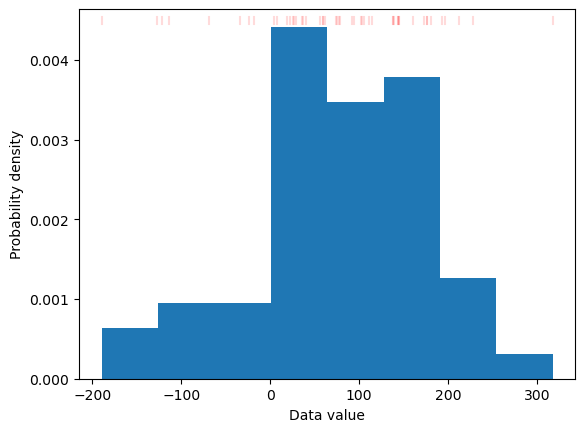

In [ ]:
#|code-fold: true
#| label: fig-prior
#| fig-cap: Histogram of the prior distribution of the sample (red lines on top).

# You can try uniform distribution as your prior
# prior = stats.uniform(0, 100)
# Or some peaked distribution like logistic
prior = stats.logistic(70, 50)

# Generate N samples
N = 50
d = np.sort(prior.rvs(size=N))

# Let us see our initial sample
plt.hist(d, bins='auto', density=True);
skip = len(d)//2000
skip = int(max(0, skip))
for s in d[::skip] if skip else d:
    plt.axvline(s, ymin=0.96, ymax=0.98, ls='-', 
                color='r', alpha=np.sqrt(1/len(d)))
plt.ylabel('Probability density');
plt.xlabel('Data value');

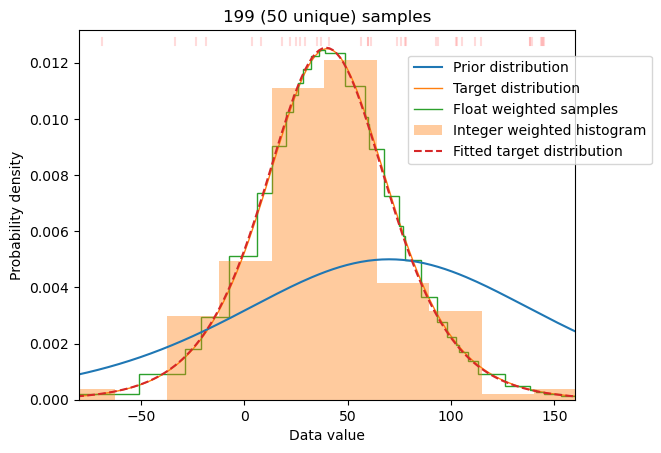

In [ ]:
#|code-fold: true
#| label: fig-posterior
#| fig-cap: Posterior distribution after application of weighting procedure. The mean and variance of the target may be selected independent of the prior sample. Try to modify `m` and `s` variables or the `target` distribution.

# Helper function
flatten = itertools.chain.from_iterable

# Proof of concept - floating point waighted data
# Target distribution, you can select any reasonable
# function which covers the data range
target = stats.logistic
m = 40
s = 20
g = target(m, s)

# Cumulative distribution function for data bins
cdf = np.zeros(len(d)+1)
cdf[1:-1] = g.cdf((d[:-1]+d[1:])/2)

# boundary cdf values for the data domain
cdf[0] = g.cdf(d[0]-(d[1]-d[0])/2)
cdf[-1] = g.cdf(d[-1]+(d[-1]-d[-2])/2)

# Data weights as change in cdf in data bin
w = cdf[1:]-cdf[:-1]

# Integer weights/data multipliers
# We will produce Nmul times the data to simulate 
# real-valued weighting
Nmul = 4
iw = Nmul*len(d)*w

# Never remove the data, block zero weights
# This will deform (rise) the wings of the histogram
iw[np.logical_and(0.25<iw, iw<1)]=1
iw = np.round(iw)

## This is a visualisation part
# Bin boundaries for data weighting
# This is for visualization only
bb = np.zeros(len(d)+1)
bb[1:-1] = (d[:-1]+d[1:])/2
bb[0] = d[0]-(d[1]-d[0])/2
bb[-1] = d[-1]+(d[-1]-d[-2])/2

# bin widths
bw = bb[1:]-bb[:-1]

plt.title(f'{iw.sum():.0f} ({len(d)} unique) samples')

x = np.linspace(d[0], d[-1], 300)

plt.plot(x, prior.pdf(x), label='Prior distribution')

plt.plot(x, g.pdf(x)/(g.cdf(bb[-1])-g.cdf(bb[0])), 
         '-', lw=1, label='Target distribution', zorder=1);

plt.stairs(w/bw/w.sum(), bb, fill=False, lw=1,
           label='Float weighted samples')
# plt.stairs(iw/bw/iw.sum(), bb, label='integer weighted samples')

Nb = max(20, len(d)//10)
plt.hist(d, weights=iw, bins=Nb, density=True, color='C1', alpha=0.4,
         label='Integer weighted histogram')

# Fit and plot target distribution to integer weighted data
fit = target.fit(list(flatten([int(wv)*[v] for v, wv in zip(d, iw)])))
plt.plot(x, target.pdf(x, *fit)*(target.cdf(bb[-1], *fit) - target.cdf(bb[0], *fit)),
                                             '--', label='Fitted target distribution')
    
skip = len(d)//2000
skip = int(max(0, skip))
for v in d[::skip] if skip else d:
    plt.axvline(v, ymin=0.96, ymax=0.98, ls='-', 
                color='r', alpha=np.sqrt(1/len(d)))

plt.ylabel('Probability density');
plt.xlabel('Data value')
plt.xlim(m-6*s, m+6*s)
plt.legend(loc='upper left', bbox_to_anchor=(0.65, 0.95));